<a href="https://www.kaggle.com/code/mateusbaldamota/eeg-psychiatric-disorders-using-ann?scriptVersionId=208869244" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Description

Author of notebook: Mateus Balda

Paper: https://www.frontiersin.org/journals/psychiatry/articles/10.3389/fpsyt.2021.707581/full

## Import from libraries

In [6]:
!pip install -q torchsummary;
!pip install -q torchviz;

# ra

: 

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import csv
import os

from xgboost import XGBClassifier
from IPython.display import FileLink
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.impute import KNNImputer

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary
from torchviz import make_dot

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN

from warnings import filterwarnings
filterwarnings('ignore')

torch.__version__

'2.4.0+cpu'

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
np.random.seed(123)
torch.manual_seed(123)

## Load dataset

In [5]:
df = pd.read_csv('../input/eeg-psychiatric-disorders-dataset/EEG.machinelearing_data_BRMH.csv')

column = 'Unnamed: 122' # column 122 is nan
df = df.drop(columns=[column])

# only PSD and FC
X_1 = df.iloc[:,8:]
y = df['main.disorder']

# quantitative variables
X_2 = df.loc[:, ['age', 'education', 'IQ']]

X_1.shape, X_2.shape, y.shape

((945, 1140), (945, 3), (945,))

In [6]:
def detect_outliers_summary(df):
    outliers_summary = {}

    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_limit) | (df[col] > upper_limit)][col]
        
        outliers_summary[col] = {
            'num_outliers': len(outliers),
            'percent_outliers': len(outliers) / len(df) * 100,
            'outliers': outliers.tolist(),
            'lower_limit': lower_limit,
            'upper_limit': upper_limit
        }

    return pd.DataFrame(outliers_summary).T


def treat_outliers_iqr(df, column, factor=1.5):
    Q1 = np.percentile(df[column], 25)
    Q3 = np.percentile(df[column], 75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    df[column] = np.clip(df[column], lower_bound, upper_bound)
        
    return _, outliers

In [7]:
outliers_summary = detect_outliers_summary(X_1)
outliers_summary['num_outliers'].sum()

26389

In [8]:
# for col in X_1.columns.tolist():
#     treat_outliers_iqr(X_1, col, factor=1.5)

### Checking/imputing Nan

In [9]:
def analyze_missing_values(dataframe):
    number_of_na_by_column = dataframe.isnull().sum().loc[lambda x: x > 0]
    
    number_of_na_rows = dataframe.isnull().any(axis=1).sum()
    
    # display(number_of_na_by_column)
    
    return number_of_na_by_column, number_of_na_rows

In [10]:
# X_1

analyze_missing_values(X_1)

(Series([], dtype: int64), 0)

In [11]:
# X_2

analyze_missing_values(X_2)

(education    15
 IQ           13
 dtype: int64,
 26)

In [12]:
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

df_imput = pd.DataFrame(knn_imputer.fit_transform(X_2[['education', 'IQ']]), columns=['education', 'IQ'])

X_2[['education', 'IQ']] = df_imput[['education', 'IQ']]

In [13]:
analyze_missing_values(X_2)

(Series([], dtype: int64), 0)

### Target `y` variable classes

`y` = main.disorder

In [14]:
column_names = np.unique(y).tolist()
column_names

['Addictive disorder',
 'Anxiety disorder',
 'Healthy control',
 'Mood disorder',
 'Obsessive compulsive disorder',
 'Schizophrenia',
 'Trauma and stress related disorder']

In [15]:
pd.DataFrame(np.unique(y))

,0
0,Addictive disorder
1,Anxiety disorder
2,Healthy control
3,Mood disorder
4,Obsessive compulsive disorder
5,Schizophrenia
6,Trauma and stress related disorder


### Class encoder

In [16]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_encoded = y_encoded.astype(np.float32)

In [17]:
pd.DataFrame(y_encoded).value_counts()

0  
3.0    266
0.0    186
6.0    128
5.0    117
1.0    107
2.0     95
4.0     46
Name: count, dtype: int64

### Transf log

In [18]:
X_2 = np.log1p(X_2)
X_2

,age,education,IQ
0,4.060443,2.669913,4.630648
1,3.637586,1.945910,4.795791
2,3.496508,2.833213,4.736198
3,3.583519,2.944439,4.844187
4,3.610918,2.833213,4.727388
...,...,...,...
940,3.135494,2.639057,4.762174
941,3.295837,2.639057,4.779123
942,3.295837,2.833213,4.736198
943,3.218876,2.639057,4.682131


## Feature importance/selection

In [19]:
def train_xgb_model(X, y, test_size=0.2, random_state=42, n_estimators=100, max_depth=6, learning_rate=0.1):

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=random_state)
    
    model = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
    
    model.fit(X_train, y_train)
    
    return model, X_train, X_test, y_train, y_test

In [20]:
# model_xgb, X_train, X_test, y_train, y_test = train_xgb_model(X_1, y_encoded)

In [21]:
# y_pred = model_xgb.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)

# print(f"Accuracy: {accuracy:.4f}")

In [22]:
# importances = model_xgb.feature_importances_

# indices = np.argsort(importances)[::-1]

# selected_number = int((X_1.shape[1])/10)

# top_features = indices[:selected_number]

# top_features

In [23]:
# X_1_top_features = X_1.iloc[:, top_features]
# X_2_top_features = pd.concat([X_2, X_1_top_features], axis=1)

# X_2_quanti = pd.concat([X_2, X_1], axis=1)

In [24]:
# X_1

In [25]:
# X_2_quanti

In [26]:
# X_1_top_features

In [27]:
# X_2_top_features

## Balance classes

In [28]:
X_2_quanti = pd.concat([X_2, X_1], axis=1)

In [29]:
# smote = SMOTE(sampling_strategy='auto', random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

# adasyn = ADASYN(sampling_strategy='auto', random_state=42, n_neighbors=5)

smote = BorderlineSMOTE(random_state=42)

# X_top_resampled, y_top_resampled = smote.fit_resample(X_1_top_features, y_encoded)
# X_2_top_resampled, y_2_top_resampled = smote.fit_resample(X_2_top_features, y_encoded)

X_all_features_resampled, y_all_features_resampled = smote.fit_resample(X_2_quanti, y_encoded)
# X_2_all_features_resampled, y_2_top_resampled = smote.fit_resample(X_2_quanti, y_encoded)

In [30]:
pd.DataFrame(y_all_features_resampled).value_counts()

0  
0.0    266
1.0    266
2.0    266
3.0    266
4.0    266
5.0    266
6.0    266
Name: count, dtype: int64

In [31]:
# for col in X_1.columns.tolist():
#     treat_outliers_iqr(X_all_features_resampled, col, factor=1.5)

In [32]:
outliers_summary = detect_outliers_summary(X_all_features_resampled)
outliers_summary['num_outliers'].sum()

61446

In [33]:
X_2 = X_all_features_resampled.loc[:, ['age', 'education', 'IQ']]
X_all_features_resampled.drop(columns=['age', 'education', 'IQ'], inplace=True)

In [34]:
pd.DataFrame(X_all_features_resampled)

,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,AB.A.delta.e.Fz,AB.A.delta.f.F4,AB.A.delta.g.F8,AB.A.delta.h.T3,AB.A.delta.i.C3,AB.A.delta.j.Cz,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
0,35.998557,21.717375,21.518280,26.825048,26.611516,25.732649,16.563408,29.891368,22.402246,22.582176,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,13.425118,11.002916,11.942516,15.272216,14.151570,12.456034,8.436832,9.975238,14.834740,10.950564,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,29.941780,27.544684,17.150159,23.608960,27.087811,13.541237,16.523963,12.775574,21.686306,18.367666,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,21.496226,21.846832,17.364316,13.833701,14.100954,13.100939,14.613650,8.063191,11.015078,11.639560,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,37.775667,33.607679,21.865556,21.771413,22.854536,21.456377,15.969042,9.434306,15.244523,17.041979,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1857,16.562446,27.632508,16.263492,15.198508,11.377521,12.433356,15.015650,10.237094,8.603530,9.747749,...,64.346925,35.208785,30.477035,45.544706,60.318937,25.504687,64.975848,17.381227,66.919523,31.864837
1858,18.687103,24.936895,15.821645,15.227341,27.228849,14.924671,13.831693,9.707966,12.599548,17.799487,...,72.375301,41.632042,42.535414,48.481163,53.180884,27.594997,56.261067,22.550225,62.832313,38.900185
1859,30.282015,27.303971,18.488827,29.947922,40.152306,42.720962,23.889057,11.113195,23.334683,40.679022,...,65.218326,40.970966,38.002354,44.525671,55.284992,23.702585,54.976024,16.021336,63.466384,27.708143
1860,17.096277,15.041191,15.996200,18.376508,26.930359,19.653401,11.648074,11.263550,17.131067,24.131289,...,80.618166,53.869549,43.620611,59.287785,69.675702,35.963907,64.584703,21.209441,62.113842,47.125557


In [35]:
pd.DataFrame(X_2)

,age,education,IQ
0,4.060443,2.669913,4.630648
1,3.637586,1.945910,4.795791
2,3.496508,2.833213,4.736198
3,3.583519,2.944439,4.844187
4,3.610918,2.833213,4.727388
...,...,...,...
1857,3.715534,2.712917,4.696353
1858,3.961227,2.563495,4.660979
1859,3.200437,2.596631,4.616117
1860,3.574768,2.637718,4.624250


## Feature extraction

In [36]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all_features_resampled)

In [37]:
X_scaled

array([[ 1.5988961 ,  0.07833824,  0.49063504, ..., -1.46312494,
        -1.87894757, -1.49937463],
       [-0.61812528, -0.8941122 , -0.57951542, ..., -1.23808485,
        -0.49671331, -0.70592394],
       [ 1.00403751,  0.60722815,  0.00247068, ..., -0.57077864,
        -0.08359108, -1.34588199],
       ...,
       [ 1.03745328,  0.58538094,  0.15207507, ..., -1.13153559,
        -0.1628086 , -1.54772286],
       [-0.25756707, -0.52759608, -0.12649131, ..., -0.8708299 ,
        -0.24296078, -0.5102468 ],
       [-0.48064258, -0.50874754, -0.52183245, ...,  1.13194588,
         0.84225885,  0.92736452]])

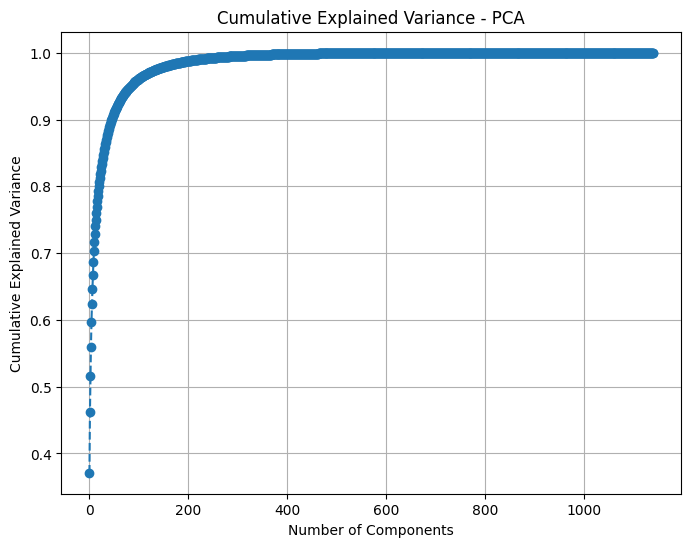

Components required for 95% of variance: 84
Components required for 99% of variance: 223


In [38]:
pca = PCA()
pca.fit(X_scaled)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

plt.figure(figsize=(8, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance - PCA')
plt.xlabel('Number of Components') 
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

n_components_95 = (cumulative_variance >= 0.95).argmax() + 1  
n_components_99 = (cumulative_variance >= 0.99).argmax() + 1  

print(f"Components required for 95% of variance: {n_components_95}")
print(f"Components required for 99% of variance: {n_components_99}")

In [39]:
pca = PCA(n_components=n_components_99)
X_pca_99 = pca.fit_transform(X_scaled)

print(f"Shape of the data after PCA with {n_components_99} components: {X_pca_99.shape}, type: {type(X_pca_99)}")

Shape of the data after PCA with 223 components: (1862, 223), type: <class 'numpy.ndarray'>


In [40]:
pd.DataFrame(X_pca_99)

,0,1,2,3,4,5,6,7,8,9,...,213,214,215,216,217,218,219,220,221,222
0,-33.042851,-3.063786,-2.096499,3.570287,-0.582739,6.888249,-2.238154,-3.557430,-2.227072,0.102341,...,-0.200539,0.106558,0.641835,-0.529035,-0.236362,0.051877,-0.003695,-0.481202,-0.389315,0.982882
1,-17.184181,-9.714039,-3.544905,-3.734123,4.912577,3.355680,-5.919132,5.613189,-5.325987,2.549948,...,-0.665741,0.711784,0.551841,0.237708,-0.256704,0.195837,-0.016307,0.101901,-0.388984,0.146000
2,-10.041829,14.351104,3.687081,-7.419535,-2.709208,2.544526,-5.907424,2.953080,-1.050259,-3.839420,...,0.348037,0.544931,0.036988,0.319521,0.192948,0.579618,-0.126388,0.256924,0.368326,-0.156236
3,-12.310047,0.384884,-6.091814,11.028865,-9.958479,4.958268,-6.029395,4.121678,-0.899281,-6.451168,...,-0.374859,-0.068000,0.247973,-0.432872,-0.224407,0.691725,0.666539,0.465550,0.111645,0.607769
4,13.879914,16.328535,-4.590380,7.153627,-2.979485,1.359319,1.137978,-2.231129,-1.545429,0.302914,...,-0.008164,0.369224,-0.432421,-0.953547,-0.358786,-0.192418,0.266385,-0.013051,0.089995,-0.237033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1857,-20.735088,-4.485997,-7.125014,4.780817,-7.565263,-3.549165,-0.164748,-3.823793,0.620422,0.035989,...,-0.148691,-0.277270,0.400480,-0.120343,0.113988,-0.210004,0.078586,0.319115,0.309346,0.023806
1858,-26.079875,1.462360,0.572368,-4.696177,-3.698793,-0.850575,-2.744517,-2.711256,0.420528,1.001620,...,-0.062743,0.273193,0.331980,0.173799,0.305168,0.520792,0.074347,0.221687,-0.026072,0.407858
1859,-25.328717,-3.737956,-2.996258,10.100057,-0.803384,6.756863,-3.816019,-2.472505,-2.319806,6.843003,...,0.018107,-0.253142,-0.250272,-0.800801,-0.432494,0.192064,0.297594,0.230052,0.304938,-0.373849
1860,-20.758973,0.908961,7.110991,10.521322,5.393746,-7.898943,-1.907898,-12.562722,0.418664,0.663388,...,-0.160031,0.700907,0.084315,-0.057536,-0.516951,-0.037638,0.172591,-0.466866,-0.592845,-0.088182


In [41]:
pd.DataFrame(y_all_features_resampled)

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
1857,6.0
1858,6.0
1859,6.0
1860,6.0


## Custom dataset PyTorch

In [42]:
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  
        self.y = torch.tensor(y, dtype=torch.long)   

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

### Split for train, val and test

In [43]:
scaler = StandardScaler()
scaler_type = type(scaler).__name__
train_ratio = 0.7
val_ratio = 0.15
batch_size = 32
output_dim = len(np.unique(y_encoded))

neurons_x = [2880, 1440, 700, 300, 140]
neurons = [1440, 700, 350, 150, 70]
neurons1 = [1024, 512, 256, 128, 64]
neurons2 = [512, 256, 128, 64, 32]
neurons3 = [256, 128, 64, 32, 16]
neurons4 = [128, 64, 32, 16, 8]

dropout = 0.10
learning_rate = 0.00001
num_epochs = 500

In [44]:
def prepare_datasets(X, y, train_ratio=train_ratio, val_ratio=val_ratio, batch_size=batch_size, scaler=None):
    
    if scaler is None:
        scaler = StandardScaler() 
    
    X_scaled = scaler.fit_transform(X)

    dataset = EEGDataset(X_scaled, y)
    
    total_size = len(dataset)
    train_size = int(train_ratio * total_size) # 70% train
    val_size = int(val_ratio * total_size) # 15% val
    test_size = total_size - train_size - val_size # 15% test

    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size]
    )
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return {
        'datasets': {
            'train': train_dataset,
            'val': val_dataset,
            'test': test_dataset,
        },
        'loaders': {
            'train': train_loader,
            'val': val_loader,
            'test': test_loader,
        },
        'X_scaled': X_scaled
    }

In [45]:
X_pca_99_quanti = pd.concat([X_2, pd.DataFrame(X_pca_99)], axis=1)
X_pca_99_quanti.columns = X_pca_99_quanti.columns.astype(str)
X_pca_99_quanti

,age,education,IQ,0,1,2,3,4,5,6,...,213,214,215,216,217,218,219,220,221,222
0,4.060443,2.669913,4.630648,-33.042851,-3.063786,-2.096499,3.570287,-0.582739,6.888249,-2.238154,...,-0.200539,0.106558,0.641835,-0.529035,-0.236362,0.051877,-0.003695,-0.481202,-0.389315,0.982882
1,3.637586,1.945910,4.795791,-17.184181,-9.714039,-3.544905,-3.734123,4.912577,3.355680,-5.919132,...,-0.665741,0.711784,0.551841,0.237708,-0.256704,0.195837,-0.016307,0.101901,-0.388984,0.146000
2,3.496508,2.833213,4.736198,-10.041829,14.351104,3.687081,-7.419535,-2.709208,2.544526,-5.907424,...,0.348037,0.544931,0.036988,0.319521,0.192948,0.579618,-0.126388,0.256924,0.368326,-0.156236
3,3.583519,2.944439,4.844187,-12.310047,0.384884,-6.091814,11.028865,-9.958479,4.958268,-6.029395,...,-0.374859,-0.068000,0.247973,-0.432872,-0.224407,0.691725,0.666539,0.465550,0.111645,0.607769
4,3.610918,2.833213,4.727388,13.879914,16.328535,-4.590380,7.153627,-2.979485,1.359319,1.137978,...,-0.008164,0.369224,-0.432421,-0.953547,-0.358786,-0.192418,0.266385,-0.013051,0.089995,-0.237033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1857,3.715534,2.712917,4.696353,-20.735088,-4.485997,-7.125014,4.780817,-7.565263,-3.549165,-0.164748,...,-0.148691,-0.277270,0.400480,-0.120343,0.113988,-0.210004,0.078586,0.319115,0.309346,0.023806
1858,3.961227,2.563495,4.660979,-26.079875,1.462360,0.572368,-4.696177,-3.698793,-0.850575,-2.744517,...,-0.062743,0.273193,0.331980,0.173799,0.305168,0.520792,0.074347,0.221687,-0.026072,0.407858
1859,3.200437,2.596631,4.616117,-25.328717,-3.737956,-2.996258,10.100057,-0.803384,6.756863,-3.816019,...,0.018107,-0.253142,-0.250272,-0.800801,-0.432494,0.192064,0.297594,0.230052,0.304938,-0.373849
1860,3.574768,2.637718,4.624250,-20.758973,0.908961,7.110991,10.521322,5.393746,-7.898943,-1.907898,...,-0.160031,0.700907,0.084315,-0.057536,-0.516951,-0.037638,0.172591,-0.466866,-0.592845,-0.088182


In [46]:
# X_top_resampled, y_top_resampled 
# X_2_top_resampled, y_2_top_resampled 

# X_all_features_resampled, y_all_features_resampled 
# X_2_all_features_resampled, y_2_top_resampled 

data = prepare_datasets(X_pca_99_quanti, y_all_features_resampled, scaler=scaler)

train_dataset = data['datasets']['train']
val_dataset = data['datasets']['val']
test_dataset = data['datasets']['test']

train_loader = data['loaders']['train']
val_loader = data['loaders']['val']
test_loader = data['loaders']['test']

X_scaled = data['X_scaled']

In [47]:
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")
print(f'X_scaled: {X_scaled.shape[1]}')

Train size: 1303
Validation size: 279
Test size: 280
X_scaled: 226


## Neural network architecture

In [48]:
class EEGClassifier(nn.Module):
    def __init__(self, input_dim, output_dim, neurons, dropout=0.10):
        super(EEGClassifier, self).__init__()
        
        self.layer1 = nn.Linear(input_dim, neurons[0])
        self.layer2 = nn.Linear(neurons[0], neurons[1])
        self.layer3 = nn.Linear(neurons[1], neurons[2])
        self.layer4 = nn.Linear(neurons[2], neurons[3])
        self.layer5 = nn.Linear(neurons[3], neurons[4])
        self.output_layer = nn.Linear(neurons[4], output_dim)

        self.bn1 = nn.BatchNorm1d(neurons[0])
        self.bn2 = nn.BatchNorm1d(neurons[1])
        self.bn3 = nn.BatchNorm1d(neurons[2])
        self.bn4 = nn.BatchNorm1d(neurons[3])
        self.bn5 = nn.BatchNorm1d(neurons[4])

        self.gelu = nn.GELU()

        self.dropout = nn.Dropout(p=dropout)
        
        init.xavier_uniform_(self.layer1.weight)
        init.xavier_uniform_(self.layer2.weight)
        init.xavier_uniform_(self.layer3.weight)
        init.xavier_uniform_(self.layer4.weight)
        init.xavier_uniform_(self.layer5.weight)
        init.xavier_uniform_(self.output_layer.weight)

    def forward(self, x):
        x = self.gelu(self.bn1(self.layer1(x))) 
        x = self.dropout(x)
        
        x = self.gelu(self.bn2(self.layer2(x)))
        x = self.dropout(x)
        
        x = self.gelu(self.bn3(self.layer3(x)))
        x = self.dropout(x)
        
        x = self.gelu(self.bn4(self.layer4(x)))
        x = self.dropout(x)
        
        x = self.gelu(self.bn5(self.layer5(x)))
        
        x = self.output_layer(x)
        
        return x

In [49]:
# choice of neuron set

selected_neurons = []

def select_neurons(input_dim):
    if input_dim <= 114:
        selected_neurons = neurons4
        
    elif input_dim <= 120:
        selected_neurons = neurons4
    
    elif input_dim <= 250:
        selected_neurons = neurons1
        
    elif input_dim <= 1140:
        selected_neurons = neurons1
        
    else:
        selected_neurons = neurons 

    return selected_neurons

In [50]:
input_dim = X_scaled.shape[1]
selected_neurons = select_neurons(input_dim)

input_dim, selected_neurons

(226, [1024, 512, 256, 128, 64])

### Network summary

In [51]:
model = EEGClassifier(input_dim, output_dim, selected_neurons, dropout)
print(f'{model}\n{input_dim}\n{output_dim}')

EEGClassifier(
  (layer1): Linear(in_features=226, out_features=1024, bias=True)
  (layer2): Linear(in_features=1024, out_features=512, bias=True)
  (layer3): Linear(in_features=512, out_features=256, bias=True)
  (layer4): Linear(in_features=256, out_features=128, bias=True)
  (layer5): Linear(in_features=128, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=7, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gelu): GELU(approximate='none')
  (dropout): Dropout(p=0.1, inplace=False)
)
226
7


In [52]:
summary(model, input_size=(input_dim, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]         232,448
       BatchNorm1d-2                 [-1, 1024]           2,048
              GELU-3                 [-1, 1024]               0
           Dropout-4                 [-1, 1024]               0
            Linear-5                  [-1, 512]         524,800
       BatchNorm1d-6                  [-1, 512]           1,024
              GELU-7                  [-1, 512]               0
           Dropout-8                  [-1, 512]               0
            Linear-9                  [-1, 256]         131,328
      BatchNorm1d-10                  [-1, 256]             512
             GELU-11                  [-1, 256]               0
          Dropout-12                  [-1, 256]               0
           Linear-13                  [-1, 128]          32,896
      BatchNorm1d-14                  [

### Network graph

In [53]:
model.eval()

sample_input = torch.randn(1, input_dim)  

output = model(sample_input)
graph = make_dot(output, params=dict(model.named_parameters()))

graph.render("eeg_classifier", format="png")

file_path = "eeg_classifier.png"

FileLink(file_path)

/kaggle/working/eeg_classifier.png

In [54]:
%%capture
# class balancing alternative

total_samples = sum([266, 186, 128, 117, 107, 95, 46])
class_frequencies = [266, 186, 128, 117, 107, 95, 46]
class_weights = [total_samples / f for f in class_frequencies]

class_weights = torch.tensor(class_weights, dtype=torch.float32)

### Criterion, optimizer and scheduler

In [55]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), 
                       lr=learning_rate,
                       weight_decay=1e-5)

scheduler = ReduceLROnPlateau(optimizer, 
                              mode='min', 
                              factor = 0.1, 
                              patience = 3, 
                              min_lr = 1e-6, 
                              verbose = True)

In [56]:
name_criterion = type(criterion).__name__
name_optimizer = type(optimizer).__name__

name_criterion, name_optimizer

('CrossEntropyLoss', 'Adam')

## Training

In [57]:
best_loss = np.inf
patience = 20
min_delta = 0.01
early_stop_counter = 0

train_losses = []
val_losses = []
val_accs = []
final_epoch = 0

for epoch in range(num_epochs):
    
    # train
    model.train()
    running_loss = 0.
    running_accuracy = 0.

    for data in train_loader:
        inputs, labels = data
        
        optimizer.zero_grad()  # zero gradients
        
        outputs = model.forward(inputs)  # input net
        
        #print(type(outputs))
        
        labels = labels.long()
        
        loss = criterion(outputs, labels)
        loss.backward()

#         outputs = F.softmax(outputs, dim=1)
#         top_p, top_class = outputs.topk(k=1, dim=1)

#         equals = top_class == labels.view(*top_class.shape)

#         running_accuracy += torch.mean(equals.type(torch.FloatTensor))

        optimizer.step()

        running_loss += loss.item()
        
#         _, predicted = torch.max(outputs.data, 1)  
#         accuracy = (predicted == labels).float().mean()
#         running_accuracy += accuracy.item()

    epoch_loss = running_loss / len(train_loader)
    #epoch_accuracy = running_accuracy / len(train_loader)
    
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    train_losses.append(epoch_loss)
    
    # val
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    correct = total = 0

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data

            outputs = model(inputs)
            labels = labels.long()

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            accuracy = (predicted == labels).float().mean()
            val_accuracy += accuracy.item()

    val_loss /= len(val_loader)
    val_accuracy /= len(val_loader)

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}\n")
    val_losses.append(val_loss)
    val_accs.append(val_accuracy)

    
    # Early stopping
    if val_loss < best_loss - min_delta:
        best_loss = val_loss
        early_stop_counter = 0  
        #best_model_state = model.state_dict()  
    else:
        early_stop_counter += 1
    
    if early_stop_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}.")
        final_epoch = epoch+1
        #model.load_state_dict(best_model_state) 
        break
        
    scheduler.step(val_loss)

Epoch [1/500], Loss: 2.1853
Validation Loss: 2.0542, Validation Accuracy: 0.1833

Epoch [2/500], Loss: 2.1584
Validation Loss: 2.0218, Validation Accuracy: 0.1846

Epoch [3/500], Loss: 2.0706
Validation Loss: 1.9958, Validation Accuracy: 0.2298

Epoch [4/500], Loss: 2.0832
Validation Loss: 1.9765, Validation Accuracy: 0.2443

Epoch [5/500], Loss: 2.0133
Validation Loss: 1.9437, Validation Accuracy: 0.2637

Epoch [6/500], Loss: 1.9518
Validation Loss: 1.9212, Validation Accuracy: 0.2637

Epoch [7/500], Loss: 1.9541
Validation Loss: 1.9067, Validation Accuracy: 0.2742

Epoch [8/500], Loss: 1.8954
Validation Loss: 1.8791, Validation Accuracy: 0.2998

Epoch [9/500], Loss: 1.8787
Validation Loss: 1.8596, Validation Accuracy: 0.2998

Epoch [10/500], Loss: 1.8192
Validation Loss: 1.8378, Validation Accuracy: 0.3380

Epoch [11/500], Loss: 1.8560
Validation Loss: 1.8214, Validation Accuracy: 0.3367

Epoch [12/500], Loss: 1.7885
Validation Loss: 1.8035, Validation Accuracy: 0.3484

Epoch [13/500

## Results

### Training/Validation Loss and Validation Accuracy

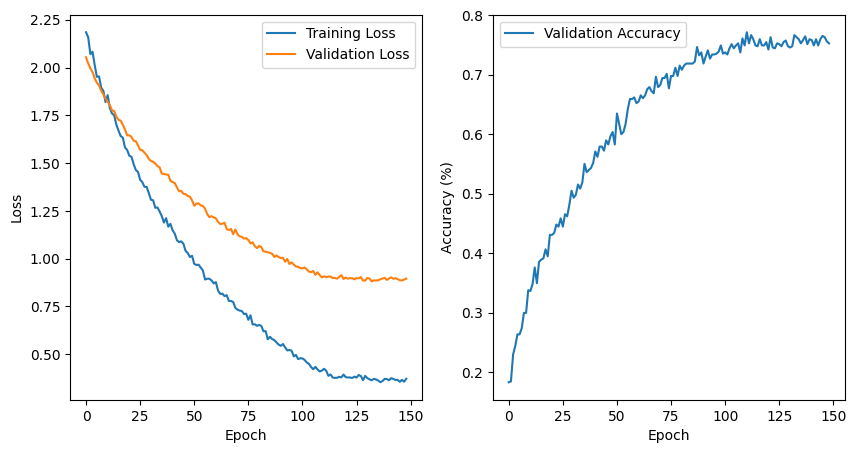

In [58]:
plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label = 'Training Loss')
plt.plot(val_losses, label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accs, label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.savefig('training_validation_plot.png')
plt.show()

### Accuracy general

In [59]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy in the test set: {accuracy:.2f}%")

Accuracy in the test set: 71.43%


### Accuracy by class

In [60]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs) 
        _, predicted = torch.max(outputs, 1)  
        all_preds.extend(predicted.cpu().numpy())  
        all_labels.extend(labels.cpu().numpy())

report = classification_report(all_labels, all_preds, target_names=column_names, digits=4)  
print(report)

                                    precision    recall  f1-score   support

                Addictive disorder     0.5667    0.5312    0.5484        32
                  Anxiety disorder     0.8095    0.8947    0.8500        38
                   Healthy control     0.6829    0.8235    0.7467        34
                     Mood disorder     0.4667    0.2979    0.3636        47
     Obsessive compulsive disorder     0.8636    0.9744    0.9157        39
                     Schizophrenia     0.7000    0.7447    0.7216        47
Trauma and stress related disorder     0.7907    0.7907    0.7907        43

                          accuracy                         0.7143       280
                         macro avg     0.6972    0.7224    0.7052       280
                      weighted avg     0.6951    0.7143    0.6998       280



### Confusion matrix by class

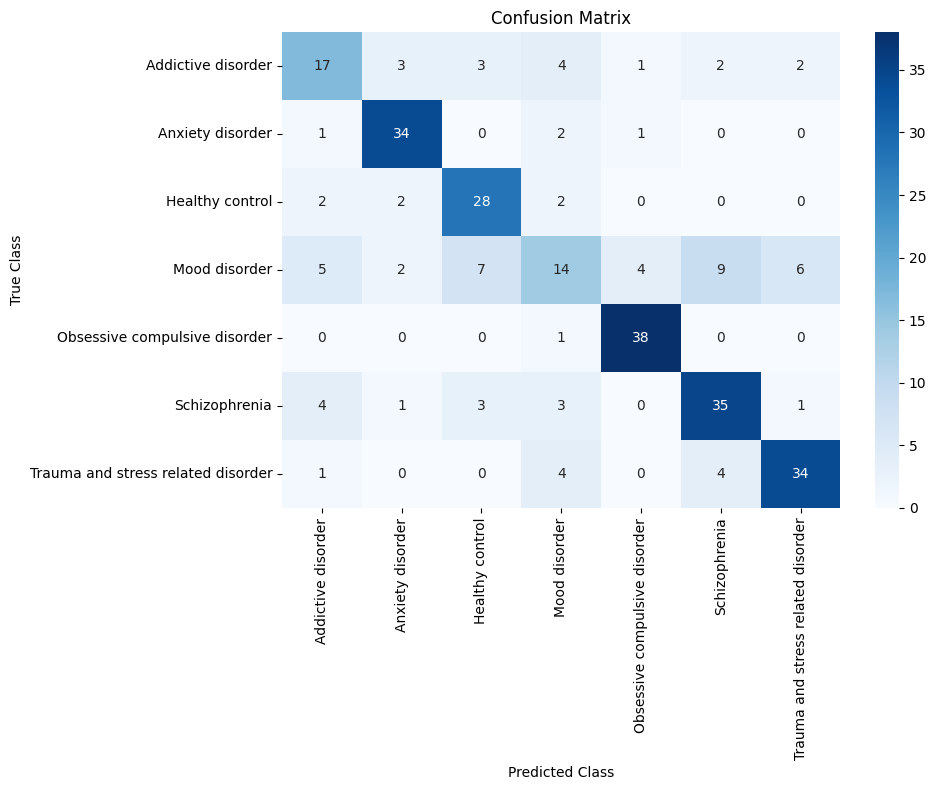

In [61]:
def plot_confusion_matrix(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)  # Model outputs
            outputs = F.softmax(outputs, dim=1)  # Probs
            top_p, top_class = outputs.topk(k=1, dim=1)  # Pred class
            all_preds.extend(top_class.cpu().numpy())  # Preds
            all_labels.extend(labels.cpu().numpy())  # True class

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    cm = confusion_matrix(all_labels, all_preds, labels=np.arange(len(class_names)))

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title(f'Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()


plot_confusion_matrix(model, test_loader, column_names)

### ROC Curves by Class

In [62]:
def evaluate_auc(model, test_loader, num_classes):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            
            probs = torch.softmax(outputs, dim=1)
            all_preds.extend(probs.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    aucs = []
    for i in range(num_classes):
        auc = roc_auc_score(all_labels == i, all_preds[:, i])
        aucs.append(auc)

    mean_auc = np.mean(aucs)
    
    print(f"AUC per class: {aucs}")
    print(f"Mean AUC: {mean_auc:.4f}")
    
    return aucs, mean_auc

aucs, mean_auc = evaluate_auc(model, test_loader, num_classes=7)

AUC per class: [0.8959173387096774, 0.9783601565898217, 0.9643711142993783, 0.8391014519221989, 0.995850622406639, 0.9331567893343073, 0.9610440584829751]
Mean AUC: 0.9383


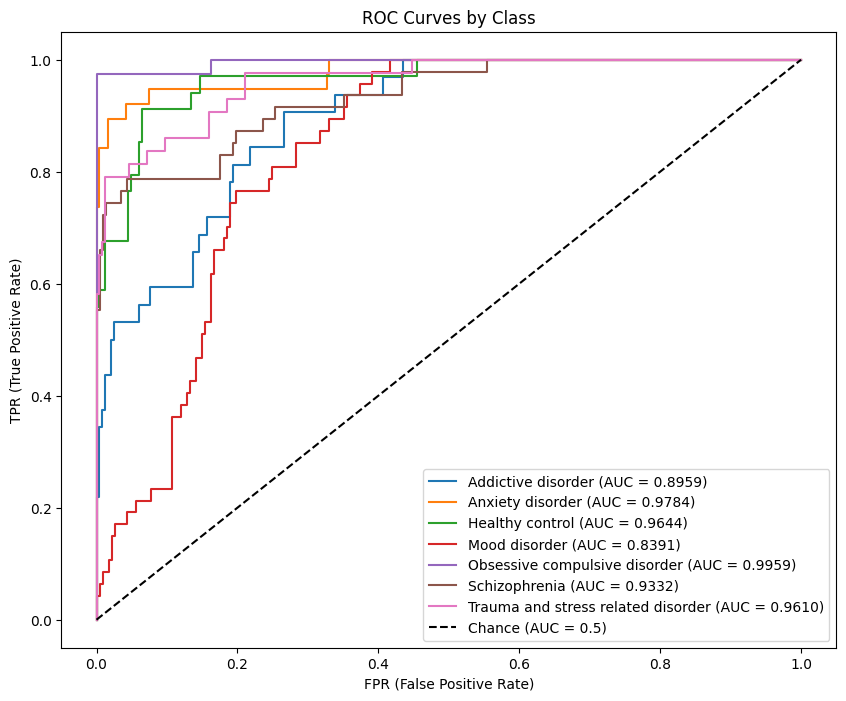

In [63]:
def plot_roc_curve(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    plt.figure(figsize=(10, 8))

    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(all_labels == i, all_preds[:, i])
        auc = roc_auc_score(all_labels == i, all_preds[:, i])
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.5)')

    plt.xlabel('FPR (False Positive Rate)')
    plt.ylabel('TPR (True Positive Rate)')
    plt.title('ROC Curves by Class')
    plt.legend(loc='lower right')
    plt.savefig('roc_curves_class.png')
    plt.show()

plot_roc_curve(model, test_loader, column_names)

In [64]:
def log_results(filename, **kwargs):
    file_exists = os.path.isfile(filename)
    
    with open(filename, mode='a', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=kwargs.keys())
        
        if not file_exists:
            writer.writeheader()
            
        writer.writerow(kwargs)
        
results_file = "results.csv"

log_results(
        results_file,
        final_epoch=final_epoch,
        number_of_neurons=selected_neurons,
        train_ratio=train_ratio,
        val_ratio=val_ratio,
        batch_size=batch_size,
        dropout=dropout,
        learning_rate=float(learning_rate),
        output_dim=output_dim,
        input_dim=input_dim,
        aucs=aucs,
        mean_auc=mean_auc,
        report=report,
        accuracy=accuracy,
    )

## Conclusions, Problems, and Limitations

* The class imbalance is evident for the multiclasses of the main.disorder variable. The SMOTE technique was applied to balance the classes and perform data augmentation.

* The data pre-processed with PSD and FC generated 1140 features. PCA with 99% variance was applied to the data, and thus 223 principal components were extracted.

* To avoid overfitting, techniques such as dropout, batch normalization, and early stopping were applied.

* The weights were initialized in the network with xavier_uniform.

* The network has convergence issues due to the high variability of the data. Despite using PCA, there were no significant improvements in performance compared to using all features from PSD and FC.

* Due to the enrichment of the data, the minority class obsessive compulsive disorder shows a tendency to overfitting, as the original data was 46 and increased to 266 with Euclidean distance.